In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs
from imblearn.under_sampling import NearMiss
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier, plot_tree

## Uyarıları Kaldirma
import warnings
warnings.simplefilter(action="ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 170)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.mode.chained_assignment = None 


In [38]:
dff = pd.read_excel("HRAttrition.xlsx")
df = dff.copy()
df.drop("EmployeeNumber", axis=1,inplace=True)
df["AttritionSeg"] = df.apply(lambda x: 1 if (x["Attrition"] == "Yes") else 0, axis=1)
df.drop("Attrition",axis=1,inplace=True)

In [39]:
df["NEW_Overtime_LowSalary"] = ((df["OverTime"] == "Yes") & (df["MonthlyIncome"] <= 4000)).astype(int)
df["NEW_Worklife_LowSalary"] = ((df["WorkLifeBalance"] == 3) & (df["MonthlyIncome"] <= 10000)).astype(int)
df["NEW_Stock_Option"] = (df["StockOptionLevel"] == 0).astype(int)
df['NEW_WorkHopRatio'] = df['TotalWorkingYears'] / df['NumCompaniesWorked']
df['NEW_SalaryRatio'] = round(((df['MonthlyIncome'] - df['MonthlyIncome'].mean()) / df['MonthlyIncome'].mean()) * 100, 2)
df['NEW_WorkHopRatio'].replace([np.inf, -np.inf], 0, inplace=True)
df['NEW_SalaryBom'] = df['MonthlyIncome'] / df['TotalWorkingYears']
df['NEW_SalaryBom'].replace([np.inf, -np.inf], 0, inplace=True)


In [5]:
cat_cols = [col for col in df.columns if df[col].dtypes == "O"]
num_cols = [col for col in df.columns if df[col].dtypes != "O"]
cat_cols = [col for col in cat_cols if col not in ["Attrition"]]


In [6]:
model1 = df[["MonthlyIncome","NEW_SalaryBom","Age"]]

In [7]:
k_range = range(2, 9)

for k in k_range:
    # Hiyerarşik kümeleme modeli oluşturma
    cluster_ea = AgglomerativeClustering(n_clusters=k, linkage="ward", affinity="euclidean")
    
    # Modeli veri üzerinde uygulama
    labels = cluster_ea.fit_predict(model1)  # X, veri setinizin ismi
    
    # Silhouette skorunu hesaplama
    silhouette_avg = silhouette_score(model1, labels)
    
    print("Küme Sayısı =", k, "için Silhouette Skoru:", silhouette_avg)

Küme Sayısı = 2 için Silhouette Skoru: 0.6767864280501189
Küme Sayısı = 3 için Silhouette Skoru: 0.6288936762088634
Küme Sayısı = 4 için Silhouette Skoru: 0.5294090105195127
Küme Sayısı = 5 için Silhouette Skoru: 0.4876457764301395
Küme Sayısı = 6 için Silhouette Skoru: 0.49323689019405625
Küme Sayısı = 7 için Silhouette Skoru: 0.5171618425571078
Küme Sayısı = 8 için Silhouette Skoru: 0.46260968257277996


In [8]:
#plt.figure(figsize = (10,7))
#plt.title("dendogram")

#linkage_method = linkage(model1, method = "ward", metric = "euclidean")
#Dendrogram = dendrogram(linkage_method)

In [9]:
cluster_ea = AgglomerativeClustering(n_clusters = 2, linkage = "ward", affinity = "euclidean")

In [10]:
cluster_labels = cluster_ea.fit_predict(model1)

In [11]:
model1["labels"] = cluster_labels

In [12]:
df["HierLabels"] = cluster_labels

In [13]:
df = pd.get_dummies(df, columns=cat_cols,drop_first=True)
df = df.astype(int)
y = df["AttritionSeg"]
X = df.drop(["AttritionSeg"], axis=1)

In [14]:
nm = NearMiss(version=3)
X_resampled, y_resampled = nm.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.30,random_state=17)

# LOGISTIC REGRESSION

In [15]:
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

y_pred = logistic_model.predict(X_test)

print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 4)}")
print(f"Recall: {round(recall_score(y_pred,y_test),4)}")
print(f"Precision: {round(precision_score(y_pred,y_test), 4)}")
print(f"F1: {round(f1_score(y_pred,y_test), 4)}")
#print(f"Auc: {round(roc_auc_score(y_pred,y_test), 4)}")
print(classification_report(y_pred, y_test))

Accuracy: 0.7483
Recall: 0.7391
Precision: 0.7391
F1: 0.7391
              precision    recall  f1-score   support

           0       0.76      0.76      0.76        74
           1       0.74      0.74      0.74        69

    accuracy                           0.75       143
   macro avg       0.75      0.75      0.75       143
weighted avg       0.75      0.75      0.75       143



# CATBOOST

In [16]:
catboost_model = CatBoostClassifier(verbose=False, random_state=12345).fit(X_train, y_train)
y_pred = catboost_model.predict(X_test)

print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 2)}")
print(f"Recall: {round(recall_score(y_pred,y_test),2)}")
print(f"Precision: {round(precision_score(y_pred,y_test), 2)}")
print(f"F1: {round(f1_score(y_pred,y_test), 2)}")
#print(f"Auc: {round(roc_auc_score(y_pred,y_test), 2)}")
print(classification_report(y_pred, y_test))

Accuracy: 0.78
Recall: 0.8
Precision: 0.71
F1: 0.75
              precision    recall  f1-score   support

           0       0.84      0.76      0.79        82
           1       0.71      0.80      0.75        61

    accuracy                           0.78       143
   macro avg       0.77      0.78      0.77       143
weighted avg       0.78      0.78      0.78       143



In [17]:
def plot_importance(model, features, num=len(X)):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()


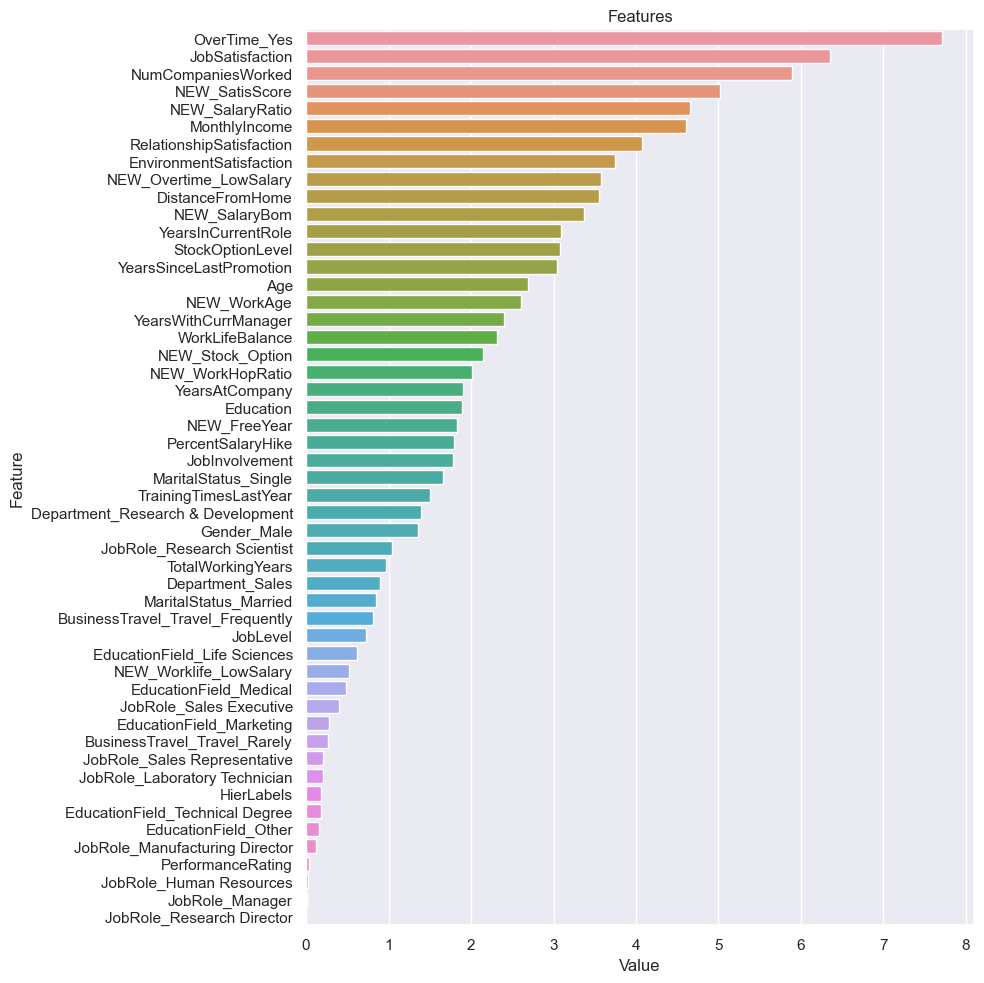

In [18]:
plot_importance(catboost_model, X)

## DECISION TREE

In [19]:
decision_model = DecisionTreeClassifier()
decision_model.fit(X_train, y_train)
y_pred = decision_model.predict(X_test)



print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 2)}")
print(f"Recall: {round(recall_score(y_pred,y_test),2)}")
print(f"Precision: {round(precision_score(y_pred,y_test), 2)}")
print(f"F1: {round(f1_score(y_pred,y_test), 2)}")
print(f"Auc: {round(roc_auc_score(y_pred,y_test), 2)}")
print(classification_report(y_pred, y_test))

Accuracy: 0.63
Recall: 0.62
Precision: 0.59
F1: 0.61
Auc: 0.63
              precision    recall  f1-score   support

           0       0.66      0.64      0.65        77
           1       0.59      0.62      0.61        66

    accuracy                           0.63       143
   macro avg       0.63      0.63      0.63       143
weighted avg       0.63      0.63      0.63       143



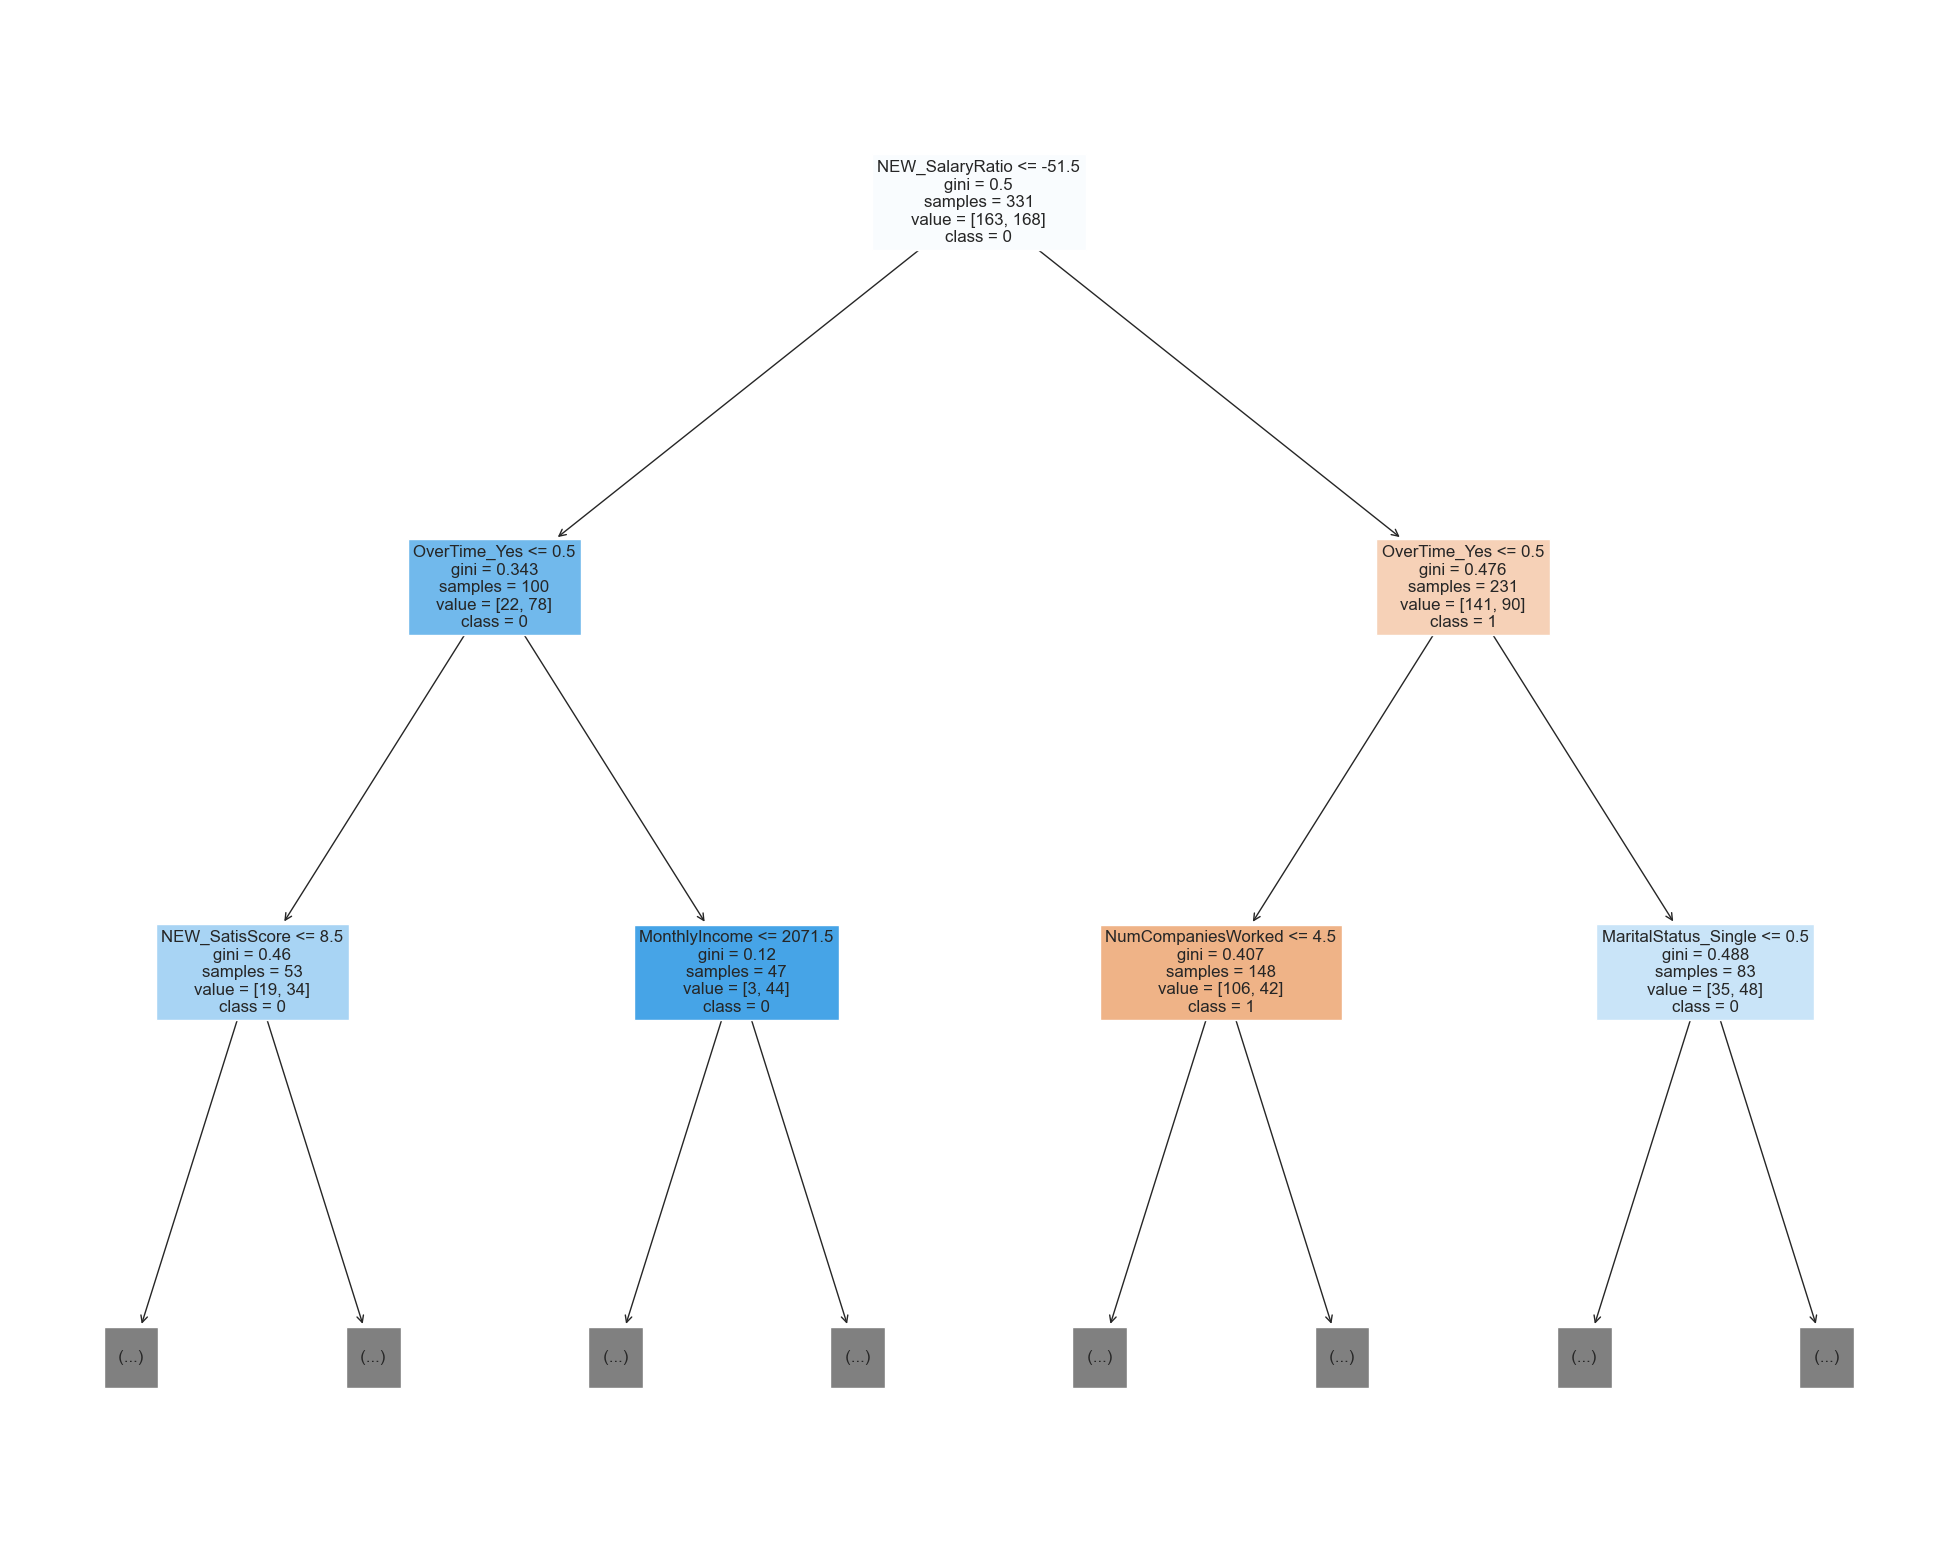

In [20]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Karar ağacını görselleştir
fig = plt.figure(figsize=(25, 20))
_ = plot_tree(decision_model, 
              feature_names=X.columns,  
              class_names=y.unique().astype(str),  # Sınıf adlarını stringe dönüştür
              filled=True,
              max_depth=2)  # Ağacı 4. seviyeye kadar kes
plt.show()


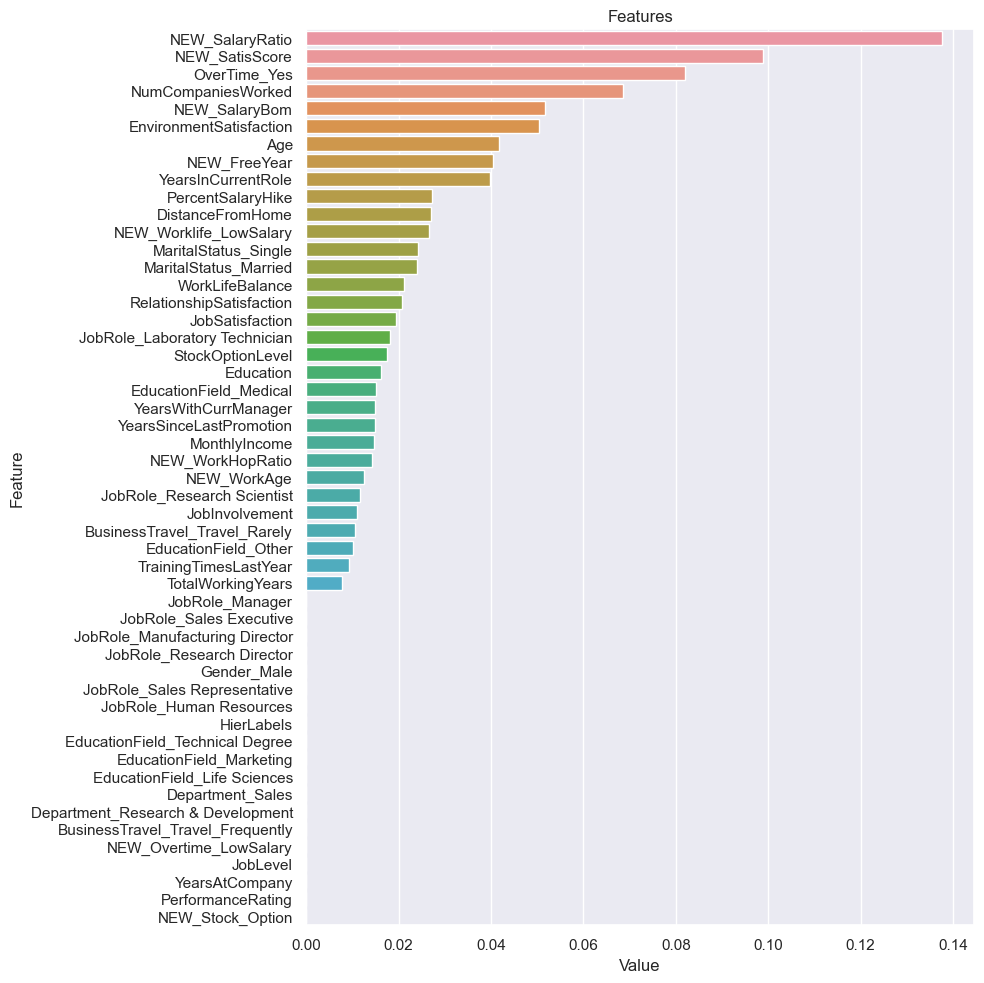

In [21]:
plot_importance(decision_model, X)

# XGB

In [22]:
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 2)}")
print(f"Recall: {round(recall_score(y_pred,y_test),2)}")
print(f"Precision: {round(precision_score(y_pred,y_test), 2)}")
print(f"F1: {round(f1_score(y_pred,y_test), 2)}")
print(f"Auc: {round(roc_auc_score(y_pred,y_test), 2)}")
print(classification_report(y_pred, y_test))

Accuracy: 0.75
Recall: 0.75
Precision: 0.72
F1: 0.74
Auc: 0.75
              precision    recall  f1-score   support

           0       0.77      0.75      0.76        76
           1       0.72      0.75      0.74        67

    accuracy                           0.75       143
   macro avg       0.75      0.75      0.75       143
weighted avg       0.75      0.75      0.75       143



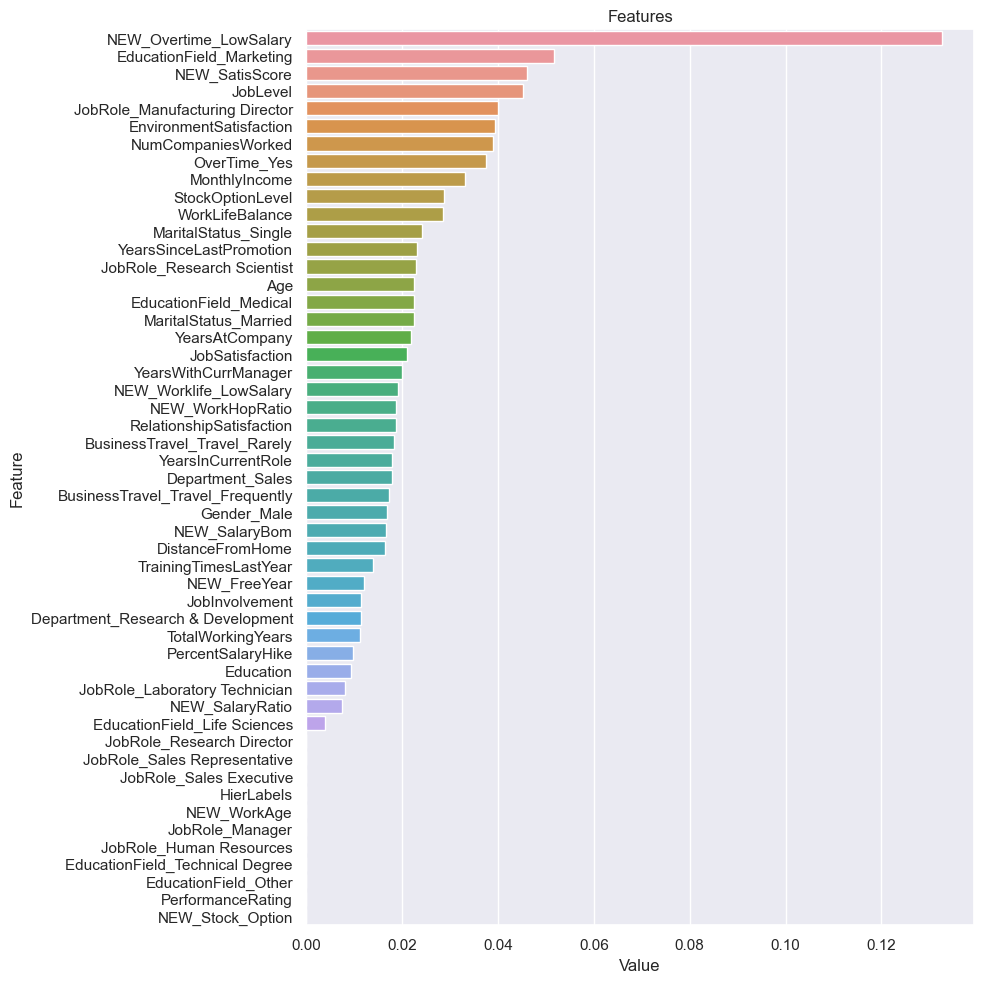

In [23]:
plot_importance(xgb_model, X)

## RANDOM FOREST

In [24]:
rf_model = RandomForestClassifier(max_depth = 8, max_features = 10, min_samples_split = 8, n_estimators = 50, random_state=17).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 2)}")
print(f"Recall: {round(recall_score(y_pred,y_test),2)}")
print(f"Precision: {round(precision_score(y_pred,y_test), 2)}")
print(f"F1: {round(f1_score(y_pred,y_test), 2)}")
#print(f"Auc: {round(roc_auc_score(y_pred,y_test), 2)}")
print(classification_report(y_pred, y_test))

Accuracy: 0.8
Recall: 0.84
Precision: 0.74
F1: 0.78
              precision    recall  f1-score   support

           0       0.86      0.78      0.82        82
           1       0.74      0.84      0.78        61

    accuracy                           0.80       143
   macro avg       0.80      0.81      0.80       143
weighted avg       0.81      0.80      0.81       143



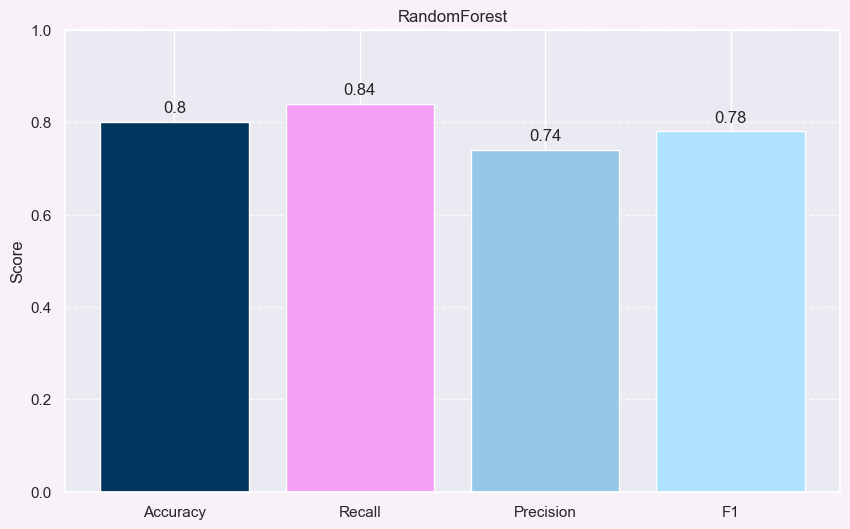

In [32]:
import matplotlib.pyplot as plt

# Metrikleri bir sözlük yapısında toplama
metrics = {'Accuracy': round(accuracy_score(y_pred, y_test), 2),
           'Recall': round(recall_score(y_pred, y_test), 2),
           'Precision': round(precision_score(y_pred, y_test), 2),
           'F1': round(f1_score(y_pred, y_test), 2)}

# Kullanmak istediğiniz renkleri tanımlayın
colors = ['#02355D', '#F2A1F4', '#93C6E7', '#AEE2FF']  # Örnek RGB renk kodları

# Çubuk grafik oluşturma
plt.figure(figsize=(10, 6), facecolor='#F8F1F8')
plt.bar(metrics.keys(), metrics.values(), color=colors)

# Eksen etiketleri ve başlık ekleme
plt.ylabel('Score')
plt.title('RandomForest')
plt.ylim(0, 1)  # Y eksenini 0 ile 1 arasında sınırla (metrikler genellikle bu aralıkta olur)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Y ekseninde ızgaraları ekler

# Değerleri gösterme
for i, v in enumerate(metrics.values()):
    plt.text(i, v + 0.02, str(v), ha='center')

# Grafiği gösterme
plt.show()


In [26]:
y_pred

array([1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1,
       0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1])

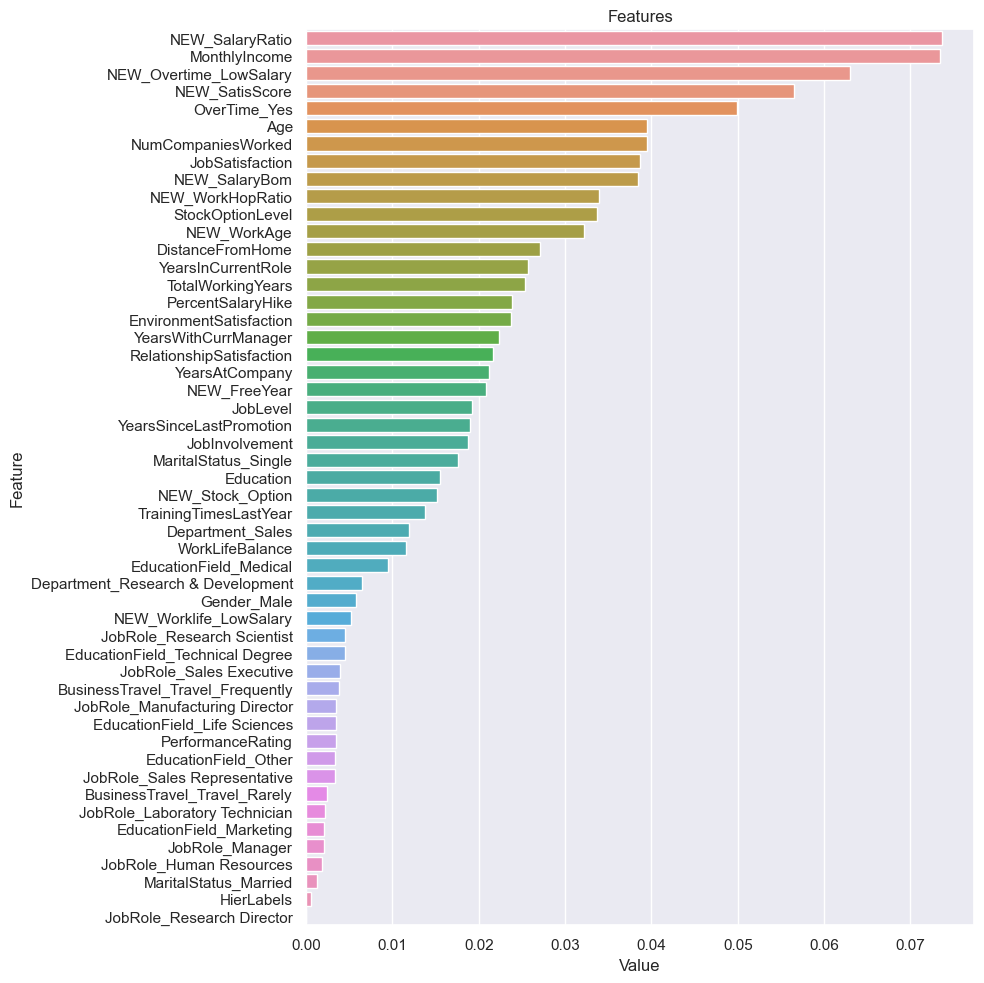

In [27]:
plot_importance(rf_model, X)